<a href="https://colab.research.google.com/github/egecandrsn/FoodPair/blob/main/FoodPair_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Welcome !

You'll find:


1. The code uses the `FoodPairModel` class to assess model performance with varying hyperparameters, like epochs, embedding dimensions, and learning rate.

2. It evaluates the model's performance in ingredient similarity, calculating correct recommendations against total recommendations for a given recipe sample.

3. The code examines co-occurrence matrices for ingredient correlations and common word pairs.

4. It demonstrates creative ingredient suggestions, starting with a set of ingredients and expanding based on similarity.

5. The code generates creative recipe ideas based on ingredient combinations.

6. It uses NLP analogies to suggest similar ingredients, e.g., finding ingredients similar to "king - man + woman."

7. The code creates ingredient clusters for insight into relationships or categories.

8. It assesses ingredient dissimilarity by finding ingredients least similar to a given ingredient.


In summary, the code explores food ingredient relationships, leveraging techniques like co-occurrence matrices and embeddings to suggest creative recipes and measure ingredient similarities.

In [ ]:
# First import necessary libraries.
import requests, gzip, ast # To download and exract the data.
import numpy as np # To doing mathematical operations.
import pandas as pd # To take a look at co-occurence matrix, not necesarry.
import matplotlib.pyplot as plt # To visualize something maybe.
from sklearn.mixture import GaussianMixture # Because of data is so noisy, we need some noise-resistant clustering model.
import random

In [ ]:
# Create a function to download, extract the data and assign it to a variable.
def dataloader(url):

  data=[]

  resp = requests.get(url, stream=True)
  with gzip.GzipFile(fileobj=resp.raw) as file:
    for line in file:
      decodline = line.decode("utf-8").strip()
      str_list=ast.literal_eval(decodline)
      data.append(str_list)
  return data

In [ ]:
# Get the data link from github repo. I love github profoundly for this reason.
url1 = 'https://github.com/egecandrsn/FoodPair/raw/main/part1.txt.gz'
url2 = 'https://github.com/egecandrsn/FoodPair/raw/main/part2.txt.gz'

data_1 = dataloader(url1)
data_2 = dataloader(url2)
data = data_1 + data_2

In [ ]:
# Look at this data size, it took nearly a month to clean it before. Yummy!
len(data), data[:5]

(2091935,
 [['nut', 'rice', 'sugar', 'vanilla', 'milk', 'butter'],
  ['beef', 'mushroom', 'chicken', 'sour cream'],
  ['black pepper', 'salt', 'cream cheese', 'corn', 'garlic', 'butter'],
  ['mushroom', 'cheese', 'chicken', 'chicken'],
  ['cracker', 'peanut butter', 'sugar', 'dark chocolate', 'butter']])

In [ ]:
# Create a function for get unique values.
def get_unique(data):
  values={}
  for line in data:
    for word in line:
      if word in values:
        values[word] += 1
      else:
        values[word] = 1
  return values

In [ ]:
# Let's take a quick look to unique food ingredients.
unique_values = get_unique(data)
unique_values = dict(sorted(unique_values.items(),key=lambda item: item[1], reverse=True))

for word, count in unique_values.items():
  print(f"{word}: {count}")

salt: 1078210
sugar: 951571
flour: 594474
egg: 571783
onion: 553316
butter: 516729
garlic: 412588
black pepper: 407164
water: 387693
milk: 379665
vanilla: 324554
bake powder: 324288
tomato: 318432
chicken: 318426
vegetable oil: 315443
: 284376
lemon: 274004
olive oil: 258746
beef: 244114
cheese: 194840
cinnamon: 178142
pork: 159528
mushroom: 149030
chili pepper: 148048
cream: 144917
celery: 144903
parsley: 142323
bread: 130195
orange: 125801
sour cream: 122976
potato: 122710
cream cheese: 117561
carrot: 115925
cheddar cheese: 115717
margarine: 111569
nut: 111040
mustard: 107277
mayonnaise: 105843
ginger: 98745
rice: 97491
parmesan: 96464
pineapple: 96119
milk chocolate: 95981
pecan: 89643
corn: 87484
bell pepper: 83083
red pepper: 81188
coconut: 80343
apple: 80071
basil: 79942
nutmeg: 77940
green onion: 77401
bacon: 77020
pasta: 72798
soy sauce: 72767
lime: 71200
oregano: 70536
green pepper: 70471
honey: 69760
shortening: 68212
thyme: 67956
bean: 66522
worcestershire: 65570
almond: 651



---


`: 284376` Did you notice this value?

It's Out Of Vocabulary token where values are deleted.
For this data, rather than removing it, keeping it is more useful for meaningful relations.


---



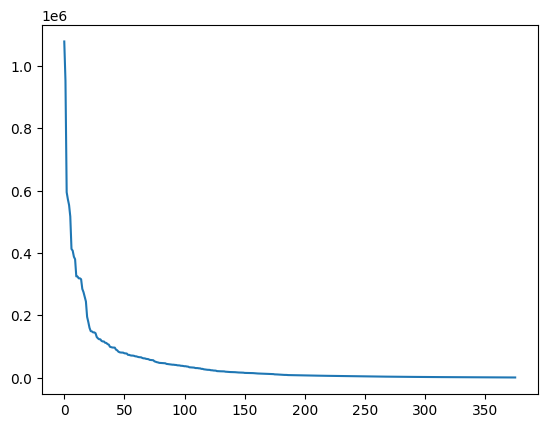

In [ ]:
# Most of the ingredient counts are less than 20.000 ~
# It is important that model should give chance to least occuring ingredients.
plt.plot(unique_values.values())
plt.show()

In [ ]:
mean = np.mean(list(unique_values.values()))
median = np.median(list(unique_values.values()))
std = np.std(list(unique_values.values()))
print("Mean : " + str(mean),"\nMedian : " + str(median),"\nSTD : " + str(std))

Mean : 45405.35372340425 
Median : 7931.0 
STD : 110800.51892480107


In [ ]:
# Create model class with some useful functions.

class FoodPairModel():
    def __init__(self, data=data):
      self.data = data
      self.create_matrix(self.data)

    def create_matrix(self, data):
      np.random.seed(0)
      vocab = set(word for line in data for word in line)
      word_index = {word: index for index, word in enumerate(vocab)}
      vocab_size = len(vocab)
      co_matrix = np.zeros((vocab_size, vocab_size))

      # Normally in NLP tasks, using a window size is a common approach. But in our data specific case,
      # all words in a line is important rather than words with similar positions in text.
      for line in data:
        for target in line:
            target_index = word_index[target]
            for context in line:
                context_index = word_index[context]
                co_matrix[target_index][context_index] += 1

      self.vocab = vocab
      self.word_index = word_index
      self.vocab_size = vocab_size
      self.co_matrix = co_matrix
      print("co_matrix created.")

    def train(self, embedding_dim=60, learning_rate=0.03, epochs=7):
      # This code defines a training method for word embeddings using a simplified version of the GloVe model (see:https://nlp.stanford.edu/pubs/glove.pdf).
      # It initializes random word vectors, and then iteratively updates them using a gradient descent approach.
      # The goal is to learn word representations that capture the co-occurrence patterns of words in a given corpus.
      np.random.seed(0)
      word_vectors = np.random.uniform(-1, 1, (self.vocab_size, embedding_dim))

      # The training process involves looping over the co-occurrence matrix and updating word vectors based on the difference
      # between the dot product of word vectors and the logarithm of co-occurrence counts.
      for epoch in range(epochs):
          for i in range(self.vocab_size):
              for j in range(self.vocab_size):
                  if self.co_matrix[i][j] > 0:
                      f_ij = np.log(self.co_matrix[i][j])
                      diff = np.dot(word_vectors[i], word_vectors[j]) - f_ij
                      grad = diff * word_vectors[j]
                      word_vectors[i] -= learning_rate * grad

      # After training, the word vectors are normalized to have unit length.
      word_vectors /= np.linalg.norm(word_vectors, axis=1)[:, np.newaxis]
      self.word_vectors = word_vectors

    def cosine_similarity(self, word1, word2):
      # For calculate similarity between two words.
      if word1 in self.word_index and word2 in self.word_index:
          vector1 = self.word_vectors[self.word_index[word1]]
          vector2 = self.word_vectors[self.word_index[word2]]
          dot_product = np.dot(vector1, vector2)
          norm1 = np.linalg.norm(vector1)
          norm2 = np.linalg.norm(vector2)
          if norm1 > 0 and norm2 > 0:
              similarity = dot_product / (norm1 * norm2)
              return similarity
      return "out-of-vocabulary"

    def vector_summation(self, l=None, N=5):
      # Calculate the N most similar words based on the vector summation method.
      if l is None:
        l = []
        while True:
            a = input("Write an ingredient:\nTo stop, press ENTER ")
            if a == "":
                break
            else:
                l.append(a)

      vector_sum = np.zeros_like(self.word_vectors[0])
      for b in l:
          b = self.word_vectors[self.word_index[b]]
          vector_sum += b

      similarities = np.dot(self.word_vectors, vector_sum)
      sorted_indices = np.argsort(similarities)[::-1]
      most_similar_words = [list(self.vocab)[i] for i in sorted_indices[1:N+1]]

      return most_similar_words

    def vector_subtraction(self, l=None, N=5):
      # Calculate the N least similar words based on the vector subsraction method.
      if l is None:
        l = []
        while True:
            a = input("Write an ingredient:\nTo stop, press ENTER ")
            if a == "":
                break
            else:
                l.append(a)

      vector_sum = np.zeros_like(self.word_vectors[0])
      for b in l:
          b = self.word_vectors[self.word_index[b]]
          vector_sum -= b

      similarities = np.dot(self.word_vectors, vector_sum)
      sorted_indices = np.argsort(similarities)[::-1]
      least_similar_words = [list(self.vocab)[i] for i in sorted_indices[1:N+1]]

      return least_similar_words

    def king_man_woman(self, king, man, woman, N=5):
      # King - Man + Woman = Queen is a popular arithmetic vector operation in NLP. Let's try out for food.
      king = self.word_vectors[self.word_index[king]]
      man = self.word_vectors[self.word_index[man]]
      woman = self.word_vectors[self.word_index[woman]]

      result = king - man + woman
      similarities = np.dot(self.word_vectors, result)
      sorted_indices = np.argsort(similarities)[::-1]
      queen = [list(self.vocab)[i] for i in sorted_indices[1:N+1]]

      return queen

    def make_cluster(self, N=30):
        # To evaluate the model, we can analyze clusters.
        word_list = list(self.word_index.keys())
        vectors = [self.word_vectors[self.word_index[word]] for word in word_list]

        # Because it is a very noisy data, we must use a different clustering approach rather than KMeans.
        gmm = GaussianMixture(n_components=N, random_state=0)
        gmm.fit(vectors)

        cluster_assignments = gmm.predict(vectors)
        word_to_cluster = {word: cluster for word, cluster in zip(word_list, cluster_assignments)}

        for cluster_id in range(N):
            words_in_cluster = [word for word, cluster in word_to_cluster.items() if cluster == cluster_id]
            print(f"Cluster {cluster_id}: {', '.join(words_in_cluster)}")

    def evaluate(self, method="summation", sample_size=5000, epochs=7, embedding_dim=70, learning_rate=0.03):
        # We don't need separate test data. We simply want a model that can recommend similar ingredients.

        # Set a random seed for reproducibility.
        random.seed(0)

        # Randomly select a sample of recipe for evaluation.
        recipe = random.sample(data, sample_size)

        # Train the model with the specified hyperparameters.
        self.train(epochs=epochs, embedding_dim=embedding_dim, learning_rate=learning_rate)

        # Initialize counters for scoring.
        score = 0
        count = 0
        for l in recipe:
            for i in range(len(l)):
                count += 1
                answer = l[i]

                # Get model predictions for similar ingredients, excluding the answer.
                if method == "summation":
                  predictions = self.vector_summation(l[:i] + l[i+1:])
                # I added this lately for disvaluete model
                else:
                  predictions = self.vector_subtraction(l[:i] + l[i+1:], N=30)

                # Check if the answer is in the list of predictions.
                if answer in predictions:
                    score += 1

        # Calculate the score as the ratio of correct recommendations to the total count.
        score = score / count
        print(f"Epochs:{epochs}, Embedding Dimensions:{embedding_dim}, Learning Rate:{learning_rate}, Score:{score}")


In [ ]:
# It can take 1.5 minutes to create co_matrix.
model = FoodPairModel()

co_matrix created.


In [ ]:
# Before dive into our model capabilities, let's explore data with co_matrix.
co_matrix_df = pd.DataFrame(model.co_matrix, columns=list(model.vocab), index=list(model.vocab))

In [ ]:
# See most correlated word pairs.
corr_matrix = co_matrix_df.corr()
mask = (corr_matrix >= 0.85) & (corr_matrix < 1)

correlation_dict = {}
for row_idx, row in corr_matrix.iterrows():
    for col_idx, value in row.items():
        if mask.loc[row_idx, col_idx]:
            correlation_dict[(row_idx, col_idx)] = value
pd.DataFrame(list(correlation_dict.values()), index=pd.MultiIndex.from_tuples(correlation_dict.keys()))

0
buttermilk      bake powder      0.894398
rice flour      xanthan gum      0.866455
nutmeg          cinnamon         0.878194
bake powder     buttermilk       0.894398
                sour milk        0.900452
                flour            0.918672
                shortening       0.888584
                egg              0.904115
                vanilla          0.881218
                sugar            0.886959
olive oil       garlic           0.865033
sour milk       bake powder      0.900452
flour           bake powder      0.918672
                shortening       0.875785
                egg              0.932725
                vanilla          0.873958
                sugar            0.903440
cocoa           vanilla          0.884273
                sugar            0.850020
cream of tartar sugar            0.851140
garlic          olive oil        0.865033
sake            mirin            0.851579
xanthan gum     rice flour       0.866455
shortening      bake powder      0.888584
                flour            0.875785
clove           cinnamon         0.871539
cinnamon        nutmeg           0.878194
                clove            0.871539
                sugar            0.867897
egg             bake powder      0.904115
                flour            0.932725
                vanilla          0.879253
                sugar            0.895667
mirin           sake             0.851579
vanilla         bake powder      0.881218
                flour            0.873958
                cocoa            0.884273
                egg              0.879253
                sugar            0.924854
sugar           bake powder      0.886959
                flour            0.903440
                cocoa            0.850020
                cream of tartar  0.851140
                cinnamon         0.867897
                egg              0.895667
                vanilla          0.924854

In [ ]:
# Also check for most occuring word-pairs.
N = 50
largest_diff_indices = []
unique = set()
for row_idx, row in co_matrix_df.iterrows():
    for col_idx, value in row.items():
        if row_idx != col_idx:
            if value not in unique:
                largest_diff_indices.append(((row_idx, col_idx), value))
                unique.add(value)

largest_diff_indices.sort(key=lambda x: x[1], reverse=True)
largest_diff_indices = largest_diff_indices[:N]

for (row_idx, col_idx), value in sorted(largest_diff_indices):
    print(f"{row_idx} - {col_idx} : {value}")

 - salt : 146304.0
 - sugar : 137547.0
bake powder - butter : 132773.0
bake powder - egg : 258259.0
bake powder - flour : 295937.0
bake powder - salt : 267085.0
bake powder - sugar : 370818.0
bake powder - vanilla : 162529.0
black pepper - garlic : 177757.0
black pepper - salt : 342335.0
butter - egg : 209962.0
butter - salt : 281758.0
butter - sugar : 358942.0
butter - vanilla : 140053.0
chicken - salt : 169868.0
cinnamon - sugar : 182060.0
egg - sugar : 446380.0
egg - vanilla : 200174.0
flour - butter : 246870.0
flour - egg : 350348.0
flour - milk : 183577.0
flour - salt : 400511.0
flour - sugar : 498329.0
flour - vanilla : 198827.0
flour - water : 136567.0
garlic - salt : 279387.0
lemon - salt : 155425.0
milk - butter : 143599.0
milk - egg : 175586.0
milk - salt : 210694.0
milk - sugar : 231776.0
olive oil - garlic : 153201.0
olive oil - salt : 198665.0
onion - beef : 165277.0
onion - black pepper : 203648.0
onion - chicken : 154723.0
onion - garlic : 206959.0
onion - salt : 350061.

In [ ]:
# Evaluate model with different hyper-parameters.
epoch = range(1,8,3)
embedding = range(30,71,20)
for epochs in epoch:
  for embedding_dim in embedding:
      model.evaluate(sample_size=5000, epochs=epochs, embedding_dim=embedding_dim, method="summation")

Epochs:1, Embedding Dimensions:30, Learning Rate:0.03, Score:0.11182980816527299
Epochs:1, Embedding Dimensions:50, Learning Rate:0.03, Score:0.10051647811116576
Epochs:1, Embedding Dimensions:70, Learning Rate:0.03, Score:0.09545007378258731
Epochs:4, Embedding Dimensions:30, Learning Rate:0.03, Score:0.21515002459419577
Epochs:4, Embedding Dimensions:50, Learning Rate:0.03, Score:0.21382193802262667
Epochs:4, Embedding Dimensions:70, Learning Rate:0.03, Score:0.19901623216920808
Epochs:7, Embedding Dimensions:30, Learning Rate:0.03, Score:0.2221839645843581
Epochs:7, Embedding Dimensions:50, Learning Rate:0.03, Score:0.22584849975405805
Epochs:7, Embedding Dimensions:70, Learning Rate:0.03, Score:0.22744712247909493


In [ ]:
# We can disvaluate model with vector_subtraction. Closer to zero, better the score.
epoch = range(1,8,3)
embedding = range(30,71,20)
for epochs in epoch:
  for embedding_dim in embedding:
      model.evaluate(sample_size=5000, epochs=epochs, embedding_dim=embedding_dim, method="subtraction")

Epochs:1, Embedding Dimensions:30, Learning Rate:0.03, Score:0.002852926709296606
Epochs:1, Embedding Dimensions:50, Learning Rate:0.03, Score:0.006960157402852927
Epochs:1, Embedding Dimensions:70, Learning Rate:0.03, Score:0.011977373339891786
Epochs:4, Embedding Dimensions:30, Learning Rate:0.03, Score:0.00012297097884899163
Epochs:4, Embedding Dimensions:50, Learning Rate:0.03, Score:0.00014756517461878997
Epochs:4, Embedding Dimensions:70, Learning Rate:0.03, Score:9.837678307919331e-05
Epochs:7, Embedding Dimensions:30, Learning Rate:0.03, Score:0.0001721593703885883
Epochs:7, Embedding Dimensions:50, Learning Rate:0.03, Score:0.00014756517461878997
Epochs:7, Embedding Dimensions:70, Learning Rate:0.03, Score:0.00014756517461878997


---


Wow! Looks like terrible but remember, we want to evaluate similarities, not prediction so %22 is quite good. Let's human eval.

---



In [ ]:
 # model.train(epochs=7,embedding_dim=50, learning_rate=0.03)

In [ ]:
# Wonderful!
model.vector_summation(["soy sauce"], N=10)

['rice vinegar',
 'sesame',
 'ginger',
 'scallion',
 'green onion',
 'red pepper',
 'garlic',
 'carrot',
 'chicken',
 'tomato sauce']

In [ ]:
# Cosine similarity
print("potato-potato:",model.cosine_similarity("potato","potato"))
print("potato-carrot:",model.cosine_similarity("potato","carrot"))
print("potato-onion:",model.cosine_similarity("potato","onion"))
print("onion-garlic:",model.cosine_similarity("onion","garlic"))
print("dark chocolate-milk chocolate:",model.cosine_similarity("dark chocolate","milk chocolate"))
print("hemp-turkey:",model.cosine_similarity("hemp","turkey"))
print("cauliflower-broccoli:",model.cosine_similarity("cauliflower","broccoli"))
print("black pepper-white pepper:",model.cosine_similarity("black pepper","white pepper"))
print("milk-cheese:",model.cosine_similarity("milk","cheese"))
print("white wine-red wine:",model.cosine_similarity("white wine","red wine"))
print("ice cream-chicken:",model.cosine_similarity("ice cream","chicken"))


potato-potato: 1.0
potato-carrot: 0.8836429787181859
potato-onion: 0.8739831486079175
onion-garlic: 0.9569235572378894
dark chocolate-milk chocolate: 0.9093854945776342
hemp-turkey: 0.09904349261033903
cauliflower-broccoli: 0.8122754690082375
black pepper-white pepper: 0.8359914644214838
milk-cheese: 0.8782398572951765
white wine-red wine: 0.8469838741386833
ice cream-chicken: 0.24156563608082993


In [ ]:
# Let's create a recipe begin with one ingredient and choose among most similar 10.
# Step 1
model.vector_summation(["cauliflower"],N=10)

['broccoli',
 'pea',
 'red onion',
 'green bean',
 'salad dress',
 'broth',
 'turmeric',
 'curry',
 'carrot',
 'red pepper']

In [ ]:
# Step 2
model.vector_summation(["cauliflower","broth"],N=10)

['broth',
 'carrot',
 'broccoli',
 'pea',
 'chicken',
 'red pepper',
 'onion',
 'mushroom',
 'bell pepper',
 'black pepper']

In [ ]:
# Step 3
model.vector_summation(["cauliflower","broth","mushroom"],N=10)

['mushroom',
 'carrot',
 'chicken',
 'onion',
 'broccoli',
 'pea',
 'black pepper',
 'garlic',
 'red pepper',
 'bell pepper']

In [ ]:
# Step 4
model.vector_summation(["cauliflower","broth","mushroom","chicken"],N=15)

['chicken',
 'mushroom',
 'onion',
 'carrot',
 'garlic',
 'black pepper',
 'bell pepper',
 'red pepper',
 'green onion',
 'pork',
 'celery',
 'tomato',
 'pea',
 'vegetable oil',
 'olive oil']

In [ ]:
# Step 5
model.vector_summation(["cauliflower","broth","mushroom","chicken","tomato",],N=15)

['onion',
 'chicken',
 'mushroom',
 'garlic',
 'black pepper',
 'carrot',
 'tomato',
 'bell pepper',
 'red pepper',
 'green onion',
 'pork',
 'olive oil',
 'beef',
 'parsley',
 'vegetable oil']



---


`["cauliflower","broth","mushroom","chicken","tomato","carrot"]`



I asked ChatGPT: `What is the perfect ratio of theese all ingredients for a good taste?`

It answered:
```
Cauliflower: 1 medium-sized cauliflower head, chopped into florets.
Broth: 4-6 cups of chicken or vegetable broth, depending on how thick you want the soup or stew.
Mushroom: About 1 cup of sliced mushrooms.
Chicken: If you're adding chicken, use 1-2 boneless, skinless chicken breasts or thighs, cut into small pieces or shredded.
Tomato: 1-2 medium-sized tomatoes, diced.
Carrot: 2-3 carrots, peeled and sliced.
```
Then i asked again:

```
Title: Cauliflower, Mushroom, and Chicken Skillet

Instructions:

1. Heat olive oil in a skillet over medium heat.

2. Sauté mushrooms until they brown, then set them aside.

3. In the same skillet, cook chicken until no longer pink.

4. Add minced garlic and sauté for 1 minute.

5. Add cauliflower and carrots; sauté until they start to soften.

6. Stir in diced tomatoes; cook for 3-5 minutes.

7. Pour in 4-6 cups of broth, season with salt and pepper, and simmer for 15-20 minutes.

8. Optionally, add heavy cream for a creamy sauce, and simmer for an extra 5 minutes.

9. Return mushrooms to the skillet and stir.

10. Adjust seasoning, garnish with parsley, and serve hot.

Enjoy this flavorful and hearty Cauliflower, Mushroom, and Chicken Skillet!
```
FoodPair_v0.1 X ChatGPT


---



In [ ]:
# Let's try to be more creative, begin with 3 different random ingredients and add more.
model.vector_summation(["chickpea","eggplant","scallion"],N=15)

['bell pepper',
 'eggplant',
 'chickpea',
 'scallion',
 'garlic',
 'zucchini',
 'red onion',
 'olive oil',
 'broth',
 'tomato',
 'cumin',
 'cayenne pepper',
 'basil',
 'black pepper',
 'cilantro']

In [ ]:
# Step 2
model.vector_summation(["chickpea","eggplant","scallion","bell pepper","zucchini"],N=15)

['bell pepper',
 'zucchini',
 'garlic',
 'broth',
 'tomato',
 'scallion',
 'olive oil',
 'black pepper',
 'red onion',
 'basil',
 'cayenne pepper',
 'onion',
 'parsley',
 'oregano',
 'cilantro']

In [ ]:
# Step 3
model.vector_summation(["chickpea","eggplant","scallion","red pepper","zucchini","basil"],N=15)

['basil',
 'bell pepper',
 'garlic',
 'zucchini',
 'olive oil',
 'tomato',
 'black pepper',
 'broth',
 'red onion',
 'parsley',
 'scallion',
 'oregano',
 'onion',
 'balsamic vinegar',
 'cayenne pepper']



---


The winners: `["chickpea","eggplant","scallion","bell pepper","zucchini","basil","balsamic vinegar"]`

And the recipe:

```
Balsamic Basil Chickpea and Roasted Vegetable Medley

Ingredients:
- 1 can (15 ounces) chickpeas, drained and rinsed
- 1 medium eggplant, cubed
- 3-4 scallions, finely chopped
- 1 medium bell pepper, diced
- 1-2 medium zucchinis, sliced or cubed
- Handful of fresh basil leaves, torn or chopped
- 2-3 tablespoons balsamic vinegar
- 3 tablespoons olive oil
- Salt and pepper to taste

Instructions:
1. Roast eggplant, bell pepper, and zucchini in olive oil at 400°F (200°C) for 20-25 minutes.
2. Sauté chickpeas in 1 tbsp olive oil until slightly crispy.
3. Combine roasted vegetables, chickpeas, and scallions in a bowl.
4. Drizzle balsamic glaze over the mixture.
5. Add fresh basil leaves and gently toss.
6. Adjust seasoning and serve as a delightful side or light main course.
```
It was really fun, huh?


---



In [ ]:
# Time to inspect analogies. Almost perfect results!
print(model.king_man_woman("soy sauce", "soy bean", "taco sauce")) # chili pepper
print(model.king_man_woman("white wine", "red wine", "dark chocolate")) # milk chocolate
print(model.king_man_woman("kahlua", "coffee", "whisky")) # irish cream
print(model.king_man_woman("cheese", "milk", "soy milk")) # tofu
print(model.king_man_woman("beef", "broth", "tart apple")) # cider
print(model.king_man_woman("black bean", "bean", "vanilla")) #cocoa
print(model.king_man_woman("apple juice", "apple", "soy bean")) #soy milk

['green onion', 'beef', 'chili pepper', 'tortilla', 'bell pepper']
['milk chocolate', 'vanilla', 'cocoa', 'pumpkin', 'bake powder']
['kahlua', 'liqueur', 'vermouth', 'irish cream', 'rum']
['tofu', 'soy bean', 'flax seed', 'zucchini', 'brown rice']
['cider', 'apple', 'apple juice', 'cranberry', 'grape']
['banana', 'bake powder', 'milk chocolate', 'cocoa', 'dark chocolate']
['flax seed', 'apple juice', 'soy milk', 'soy sauce', 'tapioca']


In [ ]:
# It make sense, acidic, sweet, nutty, starchy, fishy or alcoholic ones together.
model.make_cluster(N=25)

Cluster 0: goat, jicama, chervil, radish, watercress, daikon, edamame
Cluster 1: sweet potato, cider, oat, apple juice, apple, pecan, nutmeg, sunflower seed, cereal, tart apple, pumpkin, walnut, allspice, maple syrup, molasses, cranberry, date, raisin, clove, cinnamon, currant, prune
Cluster 2: marinara sauce, pesto sauce, black olive, eggplant, olive, artichoke, squash, mozzarella cheese, zucchini, pasta, spinach, pine nut, basil, mixed herb, caper, broccoli, green olive, parmesan, oregano, italian seasoning, ricotta, anchovy, cauliflower
Cluster 3: bouillon, horseradish, tabasco sauce, mixed seasoning, swiss cheese, worcestershire, creole season, caraway, peppercorn, stock, green pepper, monosodium glutamate, sauerkraut, dill, poultry season, marjoram, pimento, cajun season, red potato, sage, okra, gravy, hot sauce
Cluster 4: pectin, semolina, pumpkin pie spice, kumquat, nori, hemp, chia seed, sour milk, pepitas, custard, muffin, stevia
Cluster 5: brownie, sprinkles, peppermint, pers

In [ ]:
# Unsimilarities make sense also.
unsimilarity = ['milk chocolate', 'garlic', 'watermelon', 'mustard',
                   'strawberry', 'onion', 'pineapple', 'cheese', 'apple',
                   'fish', 'banana', 'pickle', 'blueberry', 'soy sauce',
                   'cabbage', 'nutella', 'orange', 'olive', 'avocado',
                   'cinnamon', 'lemon', 'parmesan', 'grapefruit',
                   'peanut butter', 'mango', 'worcestershire', 'pomegranate',
                   'mayonnaise', 'kiwi', 'horseradish', 'peach', 'taco sauce']
for i in unsimilarity:
  a = model.vector_subtraction([i], N=2)
  print(i,a)

milk chocolate ['pickle spice', 'rom']
garlic ['irish cream', 'frosting']
watermelon ['gravy', 'white sauce']
mustard ['paraffin', 'brownie']
strawberry ['picante sauce', 'bok choy']
onion ['irish cream', 'frosting']
pineapple ['juniper', 'nori']
cheese ['pickle spice', 'pectin']
apple ['rom', 'taco sauce']
fish ['kahlua', 'pumpkin pie spice']
banana ['alfredo sauce', 'spaghetti sauce']
pickle ['ricotta', 'melon']
blueberry ['pepperoni', 'chestnut']
soy sauce ['whipping cream', 'truffle']
cabbage ['irish cream', 'kahlua']
nutella ['collard', 'kale']
orange ['doritos', 'tartar sauce']
olive ['toffee', 'nutella']
avocado ['sprinkles', 'frosting']
cinnamon ['tartar sauce', 'doritos']
lemon ['nutella', 'paraffin']
parmesan ['pectin', 'pudding']
grapefruit ['sauerkraut', 'garam masala']
peanut butter ['alfredo sauce', 'caviar']
mango ['rye flour', 'gravy']
worcestershire ['semolina', 'frosting']
pomegranate ['nori', 'white sauce']
mayonnaise ['goat', 'nutella']
kiwi ['leek', 'anchovy']
hors

### **Future Work:**


* Getting better data with cuisine type, cooking techniques, ingredient amounts
* Combining recipe data with food flavors data ([for example](https://foodb.ca/downloads))
* Using gastronomy literature as data to better recommendations
* Ingredient ratio-measurement prediction
* For different cuisines, different ingredient recommendation
* Best cooking technique for given ingredients
* Human feedback reinforcement learning and collaborative filtering for personalized recommendations
* Using Genarative AI for creating fine-tuned directions and recipe's with images

